LaTeX macros (hidden cell)

$$
\renewcommand{\Q}{\mathcal{Q}}
\renewcommand{\ECov}{\boldsymbol{\Sigma}}
\renewcommand{\EMean}{\boldsymbol{\mu}}
\renewcommand{\EAlpha}{\boldsymbol{\alpha}}
\renewcommand{\EBeta}{\boldsymbol{\beta}}
\renewcommand{\P}{\mathcal{P}}
$$

In [1]:
import pandas as pd
import numpy as np
import cvxpy as cp

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
from tqdm import tqdm

# internal utils
from utils import *

In [2]:
# autoreload modified libraries
%load_ext autoreload
%autoreload 2

# Experiment setup

As we don't have real data, let's benchmark the speed of optimization algorithms against ReHLine-PO for the following simulated data (partially copied from [this paper](https://www.math.uwaterloo.ca/~ltuncel/publications/corr2006-19.pdf)):

| Dataset type  | Description  |
|---|---|
| Dense data  | $G = C^T C$ where $C_{ij} \sim Unif(-0.5, 0.5)$|
| Sparse data  | $G = L L^T$ sparse positive semi-definite matrix s.t. $(L_{ij} | L_{ij} \neq 0) \sim Unif(l, r)$ and $\#\{L_{ij} \neq 0\} = \frac{1}{2}N(N-1) \times \rho$ where $\rho$ is a density parameter. |

_Setting:_ solve the following problem
$$\min_{\mathbf{w} \in \mathbb{R}^n} \frac{\alpha}{2} \mathbf{w}^T \mathbf{G} \mathbf{w} - \mathbf{\mu}^T \mathbf{w} + \sum_{i=1}^n \phi_i(w_i), \; \; \; \; \text{s.t. } \mathbf{A w} \leq \mathbf{b} (*)$$

where $\phi_i$-s are piece-wise linear convex functions. Assume for simplicity $\mathbf{w}^{pre} = \mathbf{0}$, i.e. no previous investing was done. For this experiment, we will assume the simplest case for transaction cost, where
$$\phi_i(w_i) = \begin{cases} v_i^+ w_i \text{, if } w_i \geq 0\\ v_i^- w_i \text{, otherwise}\end{cases}$$

_Compare ReHLine-PO with_:

1. Turning the problem into QP and solve using `MOSEK`, `CVXPY` to solve it.
2. Block Successive Upper bound Minimization algorithm described in [Zhao et al](https://palomar.home.ece.ust.hk/papers/2018/ZhaoPalomar2018%20-%20Markowitz%20options%20portfolio.pdf)
3. `PyPortfolioOpt` (which uses `CVXPY` as its optimization-engine) - no need to run it in the experiment as its eigenvalue finding algo stops working from around $N=120$


**Remark**:

Certain experiments may take unusually long time (set parameters accordingly to your likings).

## Dense covariance
Let's first check ReHLine-PO's convergence.

Iter 0, dual_objfn = 139.881, primal_objfn = 41.812, xi_diff = 4.15639, beta_diff = 9.27857
Iter 100, dual_objfn = -37.3413, primal_objfn = 38.4575, xi_diff = 0.0380563, beta_diff = 0.109023
Iter 200, dual_objfn = -38.1785, primal_objfn = 38.3667, xi_diff = 0.00127461, beta_diff = 0.00361301
Iter 300, dual_objfn = -38.1797, primal_objfn = 38.3574, xi_diff = 0.000512812, beta_diff = 0.000573124
Iter 400, dual_objfn = -38.1798, primal_objfn = 38.3577, xi_diff = 0.00017445, beta_diff = 0.000658927
*** Iter 449, free variables converge; next test on all variables
Iter 500, dual_objfn = -38.2951, primal_objfn = 38.3312, xi_diff = 0.00102382, beta_diff = 0.00309128
Iter 600, dual_objfn = -38.296, primal_objfn = 38.3154, xi_diff = 0.000375358, beta_diff = 0.000502841
Iter 700, dual_objfn = -38.2961, primal_objfn = 38.3115, xi_diff = 0.000125578, beta_diff = 0.00020028
*** Iter 737, free variables converge; next test on all variables
Iter 800, dual_objfn = -38.3043, primal_objfn = 38.3079, xi_

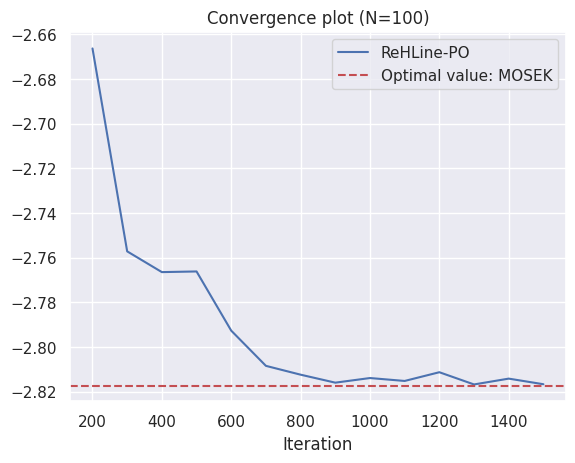

In [10]:
from utils import *
from tqdm import tqdm


N = 100
max_iter = 10000
tol = 1e-4
trace_freq = 100
vp, vm = 0.01*np.ones(N), 0.02*np.ones(N)
risk_aversion = 2.0
lb, ub = -1.0, 1.0

mu = np.random.uniform(-0.5, 0.5, N)
C = np.random.uniform(-0.5, 0.5, (N, N))
cov = C.T @ C

ws_rehline, _rehline_opt = max_quad_util_portf_rehline(N=N, mu=mu, cov=cov, risk_aversion=risk_aversion, vp=vp, vm=vm, lb=lb, ub=ub, tol=tol, max_iter=max_iter, trace_freq=trace_freq, verbose=True)

ws_mosek = max_quad_util_portf_mosek(N=N, mu=mu, cov=cov, risk_aversion=risk_aversion, vp=vp, vm=vm, lb=lb, ub=ub)
util_mosek = eval_quad_util(ws_mosek, N=N, mu=mu, cov=cov, risk_aversion=risk_aversion, vp=vp, vm=vm)

n_iters = len(_rehline_opt.primal_obj_)
plt.plot(range(2*trace_freq, trace_freq*(n_iters+1), trace_freq), _rehline_opt.primal_obj_[1:], label="ReHLine-PO")
plt.axhline(y=util_mosek, color='r', linestyle='--', label="Optimal value: MOSEK")
plt.xlabel("Iteration")
plt.legend()
plt.title(f"Convergence plot (N={N}): dense matrix")
plt.show()

_Remark_: Note that sometimes the ReHLine-PO's objective function goes lower than the optimal value. The reason for this is, technically, the value in the plot isn't $\frac{C}{2} w^T S w - \mu^T w + \sum_i \phi_i(w_i)$, but rather a primal objective with the addition of constraint penalization terms. For details, please check the original ReHLine paper. 

In [42]:
risk_aversion = 2.0
lb, ub = -1.0, 1.0
tol = 1e-3
max_iter = 1000

Ns = range(50, 2000, 50)
n_pts = len(Ns)
n_tries = 10

mean_exec_times_mosek, mean_exec_times_rehline = np.zeros(n_pts), np.zeros(n_pts)
mean_exec_times_cholesky, mean_exec_times_cholesky_inv = np.zeros(n_pts), np.zeros(n_pts)
std_exec_times_mosek, std_exec_times_rehline = np.zeros(n_pts), np.zeros(n_pts)
std_exec_times_cholesky, std_exec_times_cholesky_inv = np.zeros(n_pts), np.zeros(n_pts)

for i, N in tqdm(enumerate(Ns)):
    exec_times_mosek, exec_times_rehline = [], []
    exec_times_cholesky, exec_times_cholesky_inv = [], []
    for _ in range(n_tries):
        N = round(N)
        mu = np.random.uniform(-0.5, 0.5, N)
        C = np.random.uniform(-0.5, 0.5, (N, N))
        cov = C.T @ C
        vp, vm = 0.01*np.ones(N), 0.02*np.ones(N)
    
        start = time.time()
        _L = LA.cholesky(cov)
        end = time.time()
        exec_times_cholesky.append(end - start)

        start = time.time()
        LA.inv(_L)
        end = time.time()
        exec_times_cholesky_inv.append(end - start)

        start = time.time()
        ws_rehline, _ = max_quad_util_portf_rehline(N=N, mu=mu, cov=cov, risk_aversion=risk_aversion, vp=vp, vm=vm, lb=lb, ub=ub, tol=tol, max_iter=max_iter)
        end = time.time()
        exec_times_rehline.append(end - start) 
        
        start = time.time()
        ws_mosek = max_quad_util_portf_mosek(N=N, mu=mu, cov=cov, risk_aversion=risk_aversion, vp=vp, vm=vm, lb=lb, ub=ub)
        end = time.time()
        exec_times_mosek.append(end - start)

    mean_exec_times_mosek[i], std_exec_times_mosek[i] = np.mean(exec_times_mosek), np.std(exec_times_mosek)
    mean_exec_times_rehline[i], std_exec_times_rehline[i] = np.mean(exec_times_rehline), np.std(exec_times_rehline)
    mean_exec_times_cholesky[i], std_exec_times_cholesky[i] = np.mean(exec_times_cholesky), np.std(exec_times_cholesky)
    mean_exec_times_cholesky_inv[i], std_exec_times_cholesky_inv[i] = np.mean(exec_times_cholesky_inv), np.std(exec_times_cholesky_inv)

39it [10:29, 16.15s/it]


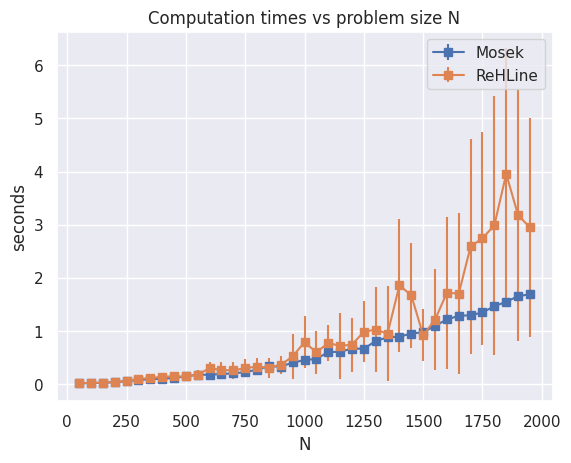

In [43]:
plt.errorbar(Ns, mean_exec_times_mosek, yerr=std_exec_times_mosek, label="Mosek", marker='s')
plt.errorbar(Ns, mean_exec_times_rehline, yerr=std_exec_times_rehline, label="ReHLine", marker='s')
# plt.errorbar(Ns, mean_exec_times_cholesky, yerr=std_exec_times_cholesky, label="Cholesky")
# plt.errorbar(Ns, mean_exec_times_cholesky_inv, yerr=std_exec_times_cholesky_inv, label="Cholesky-inv")
plt.xlabel("N")
plt.ylabel("seconds")
plt.title("Computation times vs problem size N")
plt.legend()
plt.show()

As we can see, ReHLine solution works considerably worse than MOSEK based portfolio optimization. Moreover, the variance across execution times seems to be way larger for ReHLine. This happens because ReHLine algorithm often (>50% of simulations) doesn't converge in 1000 iterations. This is due to the fact that the `tol` term we set is too conservative. 

In [55]:
risk_aversion = 2.0
lb, ub = -1.0, 1.0
tol = 5e-4

N = 100
n_pts = len(Ns)
n_tries = 1000
max_iter = 10000

utils_rehline, utils_mosek = np.zeros(n_tries), np.zeros(n_tries)
n_iters_rehline = np.zeros(n_tries)
for i in tqdm(range(n_tries)):
    mu = np.random.uniform(-0.5, 0.5, N)
    C = np.random.uniform(-0.5, 0.5, (N, N))
    cov = C.T @ C
    vp, vm = 0.01*np.ones(N), 0.02*np.ones(N)

    ws_rehline, _rehline_opt = max_quad_util_portf_rehline(N=N, mu=mu, cov=cov, risk_aversion=risk_aversion, vp=vp, vm=vm, lb=lb, ub=ub, tol=tol, max_iter=max_iter)
    ws_mosek = max_quad_util_portf_mosek(N=N, mu=mu, cov=cov, risk_aversion=risk_aversion, vp=vp, vm=vm, lb=lb, ub=ub)

    util_rehline = eval_quad_util(ws_rehline, N=N, mu=mu, cov=cov, risk_aversion=risk_aversion, vp=vp, vm=vm)
    util_mosek = eval_quad_util(ws_mosek, N=N, mu=mu, cov=cov, risk_aversion=risk_aversion, vp=vp, vm=vm)
    utils_rehline[i], utils_mosek[i] = util_rehline, util_mosek
    n_iters_rehline[i] = _rehline_opt.n_iter_

100%|███████████████████████████████████████| 1000/1000 [00:45<00:00, 21.80it/s]


In [22]:
N = 100
mu = np.random.uniform(-0.5, 0.5, N)
C = np.random.uniform(-0.5, 0.5, (N, N))
cov = C.T @ C
np.linalg.eigvalsh(cov)

array([4.76878427e-04, 7.50794616e-03, 1.57824043e-02, 2.59003793e-02,
       5.02027869e-02, 5.93127782e-02, 6.62059152e-02, 7.74899620e-02,
       1.67462195e-01, 2.00624029e-01, 2.17175448e-01, 2.79434219e-01,
       3.08486463e-01, 3.56935620e-01, 4.08915750e-01, 4.16038563e-01,
       4.94229218e-01, 6.12679143e-01, 7.06523344e-01, 7.83223993e-01,
       8.93641818e-01, 9.42320943e-01, 9.60906883e-01, 1.17031514e+00,
       1.18350374e+00, 1.36485635e+00, 1.42722878e+00, 1.56464108e+00,
       1.68065455e+00, 1.80680233e+00, 1.91841882e+00, 2.01967487e+00,
       2.11512477e+00, 2.32748417e+00, 2.55433210e+00, 2.65486934e+00,
       2.83080057e+00, 3.01340577e+00, 3.21918276e+00, 3.37189797e+00,
       3.59965979e+00, 3.72008652e+00, 3.88104543e+00, 4.06007168e+00,
       4.23504342e+00, 4.57512490e+00, 4.68099769e+00, 4.93999672e+00,
       4.99010753e+00, 5.13834413e+00, 5.37988714e+00, 5.68579514e+00,
       5.81916585e+00, 6.30993965e+00, 6.36278734e+00, 6.59234189e+00,
      

In [56]:
print("ReHLine didn't converge in {} out of {} tries".format(
    sum(n_iter == max_iter for n_iter in n_iters_rehline), n_tries))

ReHLine didn't converge in 44 out of 1000 tries


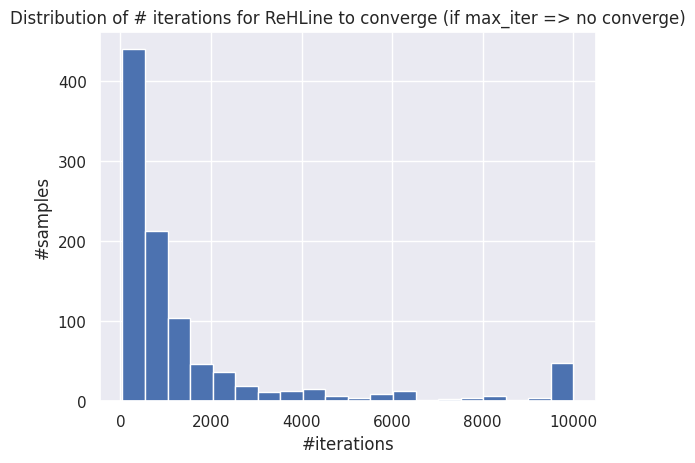

In [57]:
plt.hist(n_iters_rehline, bins=20)
plt.title("Distribution of # iterations for ReHLine to converge (if max_iter => no converge)")
plt.xlabel("#iterations")
plt.ylabel("#samples")
plt.show()

In [61]:
relative_perf_rehline[n_iters_rehline < max_iter].mean(), relative_perf_rehline[n_iters_rehline < max_iter].std()

(-1.098652501539059, 19.108021025890142)

In [62]:
relative_perf_rehline.mean(), relative_perf_rehline.std()

(-2.9181464486920268, 21.84261142894777)

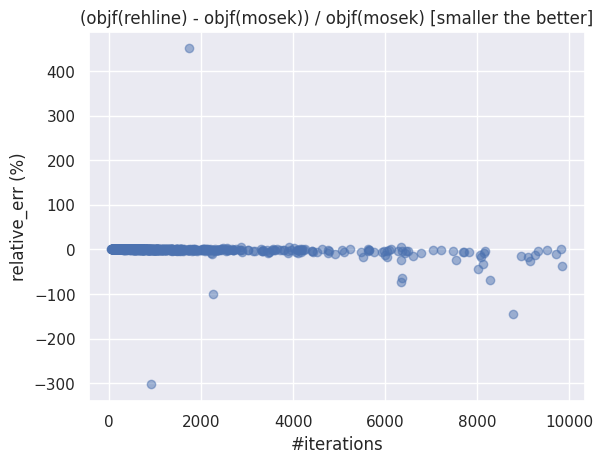

In [64]:
relative_perf_rehline = (utils_rehline - utils_mosek) / utils_mosek * 100.0
plt.scatter(n_iters_rehline[n_iters_rehline < max_iter], relative_perf_rehline[n_iters_rehline < max_iter], alpha=0.5)
plt.title("(objf(rehline) - objf(mosek)) / objf(mosek) [smaller the better]")
plt.xlabel("#iterations")
plt.ylabel("relative_err (%)")
plt.show()

## Sparse covariance

Iter 0, dual_objfn = 109.033, primal_objfn = 76.1218, xi_diff = 2.97694, beta_diff = 12.2637
Iter 10, dual_objfn = 9.01915, primal_objfn = 75.6991, xi_diff = 0.767203, beta_diff = 0.460411
Iter 20, dual_objfn = -25.4989, primal_objfn = 75.7619, xi_diff = 0.371582, beta_diff = 0.316455
Iter 30, dual_objfn = -42.5923, primal_objfn = 74.1643, xi_diff = 0.246209, beta_diff = 0.193673
Iter 40, dual_objfn = -53.8088, primal_objfn = 74.1518, xi_diff = 0.169672, beta_diff = 0.126361
Iter 50, dual_objfn = -60.7681, primal_objfn = 74.0536, xi_diff = 0.126872, beta_diff = 0.124764
Iter 60, dual_objfn = -64.9874, primal_objfn = 74.4414, xi_diff = 0.11474, beta_diff = 0.153216
Iter 70, dual_objfn = -67.5546, primal_objfn = 74.6625, xi_diff = 0.0682555, beta_diff = 0.132821
Iter 80, dual_objfn = -69.3013, primal_objfn = 73.9051, xi_diff = 0.0555933, beta_diff = 0.0831905
Iter 90, dual_objfn = -70.3651, primal_objfn = 73.3613, xi_diff = 0.0492084, beta_diff = 0.170676
Iter 100, dual_objfn = -71.159, 

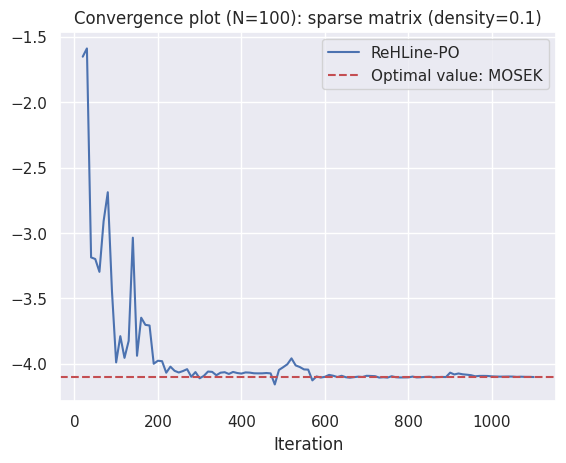

In [7]:
from utils import *

N = 100
max_iter = 10000
tol = 1e-4
trace_freq = 10
vp, vm = 0.01*np.ones(N), 0.02*np.ones(N)
risk_aversion = 2.0
lb, ub = -1.0, 1.0
density = 0.1

mu = np.random.uniform(-0.5, 0.5, N)
cov = random_sparse_spd_matrix(dim=N, density=density)

ws_rehline, _rehline_opt = max_quad_util_portf_rehline(N=N, mu=mu, cov=cov, risk_aversion=risk_aversion, vp=vp, vm=vm, lb=lb, ub=ub, tol=tol, max_iter=max_iter, trace_freq=trace_freq, verbose=True)

ws_mosek = max_quad_util_portf_mosek(N=N, mu=mu, cov=cov, risk_aversion=risk_aversion, vp=vp, vm=vm, lb=lb, ub=ub)
util_mosek = eval_quad_util(ws_mosek, N=N, mu=mu, cov=cov, risk_aversion=risk_aversion, vp=vp, vm=vm)

n_iters = len(_rehline_opt.primal_obj_)
plt.plot(range(2*trace_freq, trace_freq*(n_iters+1), trace_freq), _rehline_opt.primal_obj_[1:], label="ReHLine-PO")
plt.axhline(y=util_mosek, color='r', linestyle='--', label="Optimal value: MOSEK")
plt.xlabel("Iteration")
plt.legend()
plt.title(f"Convergence plot (N={N}): sparse matrix (density={density})")
plt.show()

In [5]:
risk_aversion = 2.0
lb, ub = -1.0, 1.0
tol = 1e-4
max_iter = 1000

Ns = range(50, 2000, 50)
n_pts = len(Ns)
n_tries = 10
density = 0.2

mean_exec_times_mosek, mean_exec_times_rehline = np.zeros(n_pts), np.zeros(n_pts)
mean_exec_times_cholesky, mean_exec_times_cholesky_inv = np.zeros(n_pts), np.zeros(n_pts)
std_exec_times_mosek, std_exec_times_rehline = np.zeros(n_pts), np.zeros(n_pts)
std_exec_times_cholesky, std_exec_times_cholesky_inv = np.zeros(n_pts), np.zeros(n_pts)

for i, N in tqdm(enumerate(Ns)):
    exec_times_mosek, exec_times_rehline = [], []
    exec_times_cholesky, exec_times_cholesky_inv = [], []
    for _ in range(n_tries):
        N = round(N)
        mu = np.random.uniform(-0.5, 0.5, N)
        cov = random_sparse_spd_matrix(dim=N, density=density)
        while np.linalg.matrix_rank(cov) < N:
            cov = random_sparse_spd_matrix(dim=N, density=density)
        vp, vm = 0.01*np.ones(N), 0.02*np.ones(N)
    
        start = time.time()
        _L = LA.cholesky(cov)
        end = time.time()
        exec_times_cholesky.append(end - start)

        start = time.time()
        LA.inv(_L)
        end = time.time()
        exec_times_cholesky_inv.append(end - start)

        start = time.time()
        ws_rehline, _ = max_quad_util_portf_rehline(N=N, mu=mu, cov=cov, risk_aversion=risk_aversion, vp=vp, vm=vm, lb=lb, ub=ub, tol=tol, max_iter=max_iter)
        end = time.time()
        exec_times_rehline.append(end - start) 
        
        start = time.time()
        ws_mosek = max_quad_util_portf_mosek(N=N, mu=mu, cov=cov, risk_aversion=risk_aversion, vp=vp, vm=vm, lb=lb, ub=ub)
        end = time.time()
        exec_times_mosek.append(end - start)

    mean_exec_times_mosek[i], std_exec_times_mosek[i] = np.mean(exec_times_mosek), np.std(exec_times_mosek)
    mean_exec_times_rehline[i], std_exec_times_rehline[i] = np.mean(exec_times_rehline), np.std(exec_times_rehline)
    mean_exec_times_cholesky[i], std_exec_times_cholesky[i] = np.mean(exec_times_cholesky), np.std(exec_times_cholesky)
    mean_exec_times_cholesky_inv[i], std_exec_times_cholesky_inv[i] = np.mean(exec_times_cholesky_inv), np.std(exec_times_cholesky_inv)

39it [11:26, 17.59s/it]


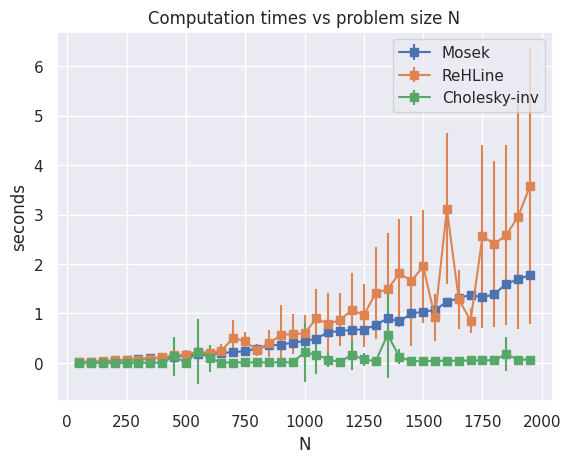

In [9]:
plt.errorbar(Ns, mean_exec_times_mosek, yerr=std_exec_times_mosek, label="Mosek", marker='s')
plt.errorbar(Ns, mean_exec_times_rehline, yerr=std_exec_times_rehline, label="ReHLine", marker='s')
# plt.errorbar(Ns, mean_exec_times_cholesky, yerr=std_exec_times_cholesky, label="Cholesky")
plt.errorbar(Ns, mean_exec_times_cholesky_inv, yerr=std_exec_times_cholesky_inv, label="Cholesky-inv", marker='s')
plt.xlabel("N")
plt.ylabel("seconds")
plt.title("Computation times vs problem size N")
plt.legend()
plt.show()

# More complex transaction function

What if, instead of a simpler form of the transaction cost $\phi_i(w_i)$, we might have several linear pieces ($L >> 1$), i.e.
$$\phi_i(w) := p_{il} w + q_{il}, \;\; \text{if} \; w \in [d_{il}, d_{il+1}] \text{ for } l=0,...,L$$
with $d_{i0} = -\infty$ and $d_{iL+1} = +\infty$. How will MOSEK and ReHLine-PO perform for different $L$-s?

Remarks:
1. Since (as we saw) results on both dense and sparse covariance matrices are pretty similar, we will simply consider random dense covariance matrices for this experiment.

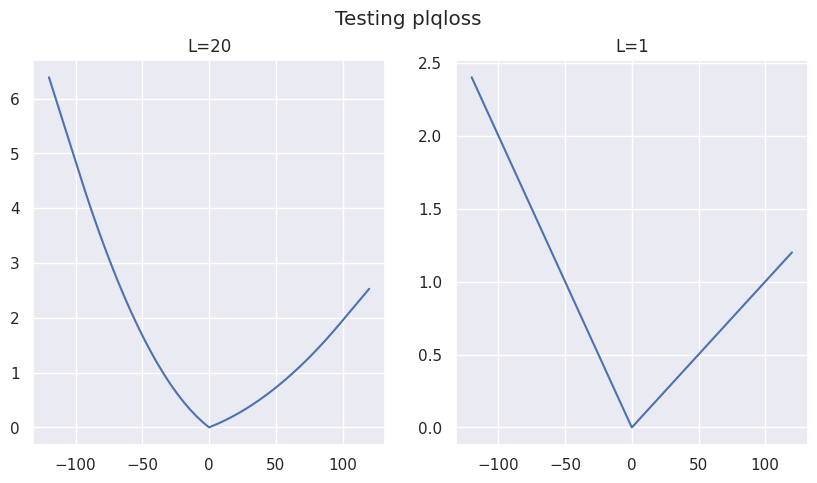

In [187]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

plqloss = create_plqloss_from_volume(V=100, L=20, vp=0.01, vm=0.02, d_vp=0.01*0.1, d_vm=0.02*0.15)
xs = np.linspace(-120, +120, 1000)
ax[0].plot(xs, plqloss(xs))
ax[0].set_title("L=20")

plqloss = create_plqloss_from_volume(V=100, L=1, vp=0.01, vm=0.02, d_vp=0.01*0.1, d_vm=0.02*0.15)
xs = np.linspace(-120, +120, 1000)
ax[1].plot(xs, plqloss(xs))
ax[1].set_title("L=1")

fig.suptitle("Testing plqloss")
plt.show()

In [ ]:
from utils import *

N = 20
L = 5
tol = 5e-4
max_iter = 1000
trace_freq = 10
verbose = False
vp, vm = 0.05, 0.1
d_vp, d_vm = 0.01*0.1, 0.02*0.15
lb, ub = -1.0, 1.0
risk_aversion = 2.0
V = 1
plqloss = create_plqloss_from_volume(V, L, vp, vm, d_vp, d_vm)
mu, cov = random_mu(N), dense_random_cov(N)

# rehline-based portfolio optimization
weights_rehlinepo, _ = max_quad_util_portf_rehline_plq(
    N=N, mu=mu, cov=cov, transaction_cost=plqloss, 
    risk_aversion=risk_aversion, lb=lb, ub=ub, 
    tol=tol, max_iter=max_iter,
)

print("Weights provided by ReHLine-PO", weights_rehlinepo)

weights_mosek = max_quad_util_portf_mosek_plq(N=N, mu=mu, cov=cov, transaction_cost=plqloss, risk_aversion=risk_aversion, lb=lb, ub=ub, debug=False)
print("Weights provided by Mosek", weights_mosek)

print("L2 diff", LA.norm(weights_mosek - weights_rehlinepo))

In [ ]:
eval_quad_util_plq(weights_mosek, N, mu, cov, risk_aversion, plqloss), eval_quad_util_plq(weights_rehlinepo, N, mu, cov, risk_aversion, plqloss)

In [12]:
from utils import *

risk_aversion = 2.0
lb, ub = -1.0, 1.0
L = 20
V = 1.0
vp, vm = 0.05, 0.1
d_vp, d_vm = 0.01*0.1, 0.02*0.15
plqloss = create_plqloss_from_volume(V, L, vp, vm, d_vp, d_vm)
tol = 5e-4
max_iter = 1000

Ns = range(50, 1500, 50)
n_pts = len(Ns)
n_tries = 10

mean_exec_times_mosek, mean_exec_times_rehline = np.zeros(n_pts), np.zeros(n_pts)
mean_exec_times_cholesky, mean_exec_times_cholesky_inv = np.zeros(n_pts), np.zeros(n_pts)
std_exec_times_mosek, std_exec_times_rehline = np.zeros(n_pts), np.zeros(n_pts)
std_exec_times_cholesky, std_exec_times_cholesky_inv = np.zeros(n_pts), np.zeros(n_pts)


for i, N in tqdm(enumerate(Ns)):
    exec_times_mosek, exec_times_rehline = [], []
    exec_times_cholesky, exec_times_cholesky_inv = [], []
    for _ in range(n_tries):
        N = round(N)
        mu = np.random.uniform(-0.5, 0.5, N)
        C = np.random.uniform(-0.5, 0.5, (N, N))
        cov = C.T @ C
    
        start = time.time()
        _L = LA.cholesky(cov)
        end = time.time()
        exec_times_cholesky.append(end - start)

        start = time.time()
        LA.inv(_L)
        end = time.time()
        exec_times_cholesky_inv.append(end - start)

        start = time.time()
        ws_rehline, _ = max_quad_util_portf_rehline_plq(
            N=N, mu=mu, cov=cov, transaction_cost=plqloss, 
            risk_aversion=risk_aversion, lb=lb, ub=ub, 
            tol=tol, max_iter=max_iter,
        )        
        end = time.time()
        exec_times_rehline.append(end - start) 
        
        start = time.time()
        ws_mosek = max_quad_util_portf_mosek_plq(
            N=N, mu=mu, cov=cov, transaction_cost=plqloss, 
            risk_aversion=risk_aversion, lb=lb, ub=ub, debug=False
        )
        end = time.time()
        exec_times_mosek.append(end - start)

    mean_exec_times_mosek[i], std_exec_times_mosek[i] = np.mean(exec_times_mosek), np.std(exec_times_mosek)
    mean_exec_times_rehline[i], std_exec_times_rehline[i] = np.mean(exec_times_rehline), np.std(exec_times_rehline)
    mean_exec_times_cholesky[i], std_exec_times_cholesky[i] = np.mean(exec_times_cholesky), np.std(exec_times_cholesky)
    mean_exec_times_cholesky_inv[i], std_exec_times_cholesky_inv[i] = np.mean(exec_times_cholesky_inv), np.std(exec_times_cholesky_inv)

29it [32:44, 67.73s/it] 


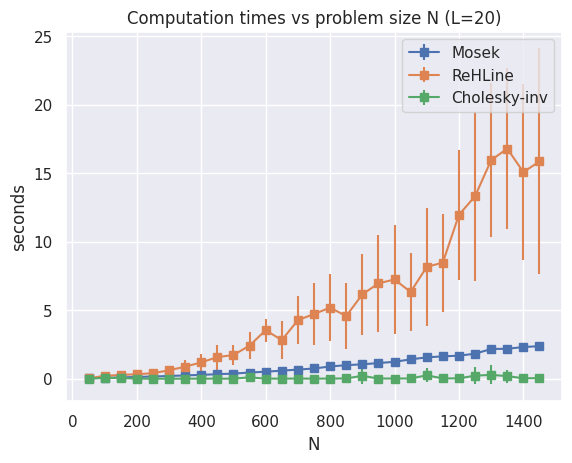

In [14]:
plt.errorbar(Ns, mean_exec_times_mosek, yerr=std_exec_times_mosek, label="Mosek", marker='s')
plt.errorbar(Ns, mean_exec_times_rehline, yerr=std_exec_times_rehline, label="ReHLine", marker='s')
# plt.errorbar(Ns, mean_exec_times_cholesky, yerr=std_exec_times_cholesky, label="Cholesky")
plt.errorbar(Ns, mean_exec_times_cholesky_inv, yerr=std_exec_times_cholesky_inv, label="Cholesky-inv", marker='s')
plt.xlabel("N")
plt.ylabel("seconds")
plt.title(f"Computation times vs problem size N (L={L})")
plt.legend()
plt.show()

In [ ]:
from utils import *

n_tries = 10
Ls = [1, 10, 50, 100]
N = 3000
risk_aversion = 2.0
lb, ub = -1.0, 1.0
V = 1.0
vp, vm = 0.05, 0.1
d_vp, d_vm = 0.01*0.1, 0.02*0.15
plqloss = create_plqloss_from_volume(V, L, vp, vm, d_vp, d_vm)
tol = 5e-4
max_iter = 1000

exec_times_mosek = np.zeros((len(Ls), n_tries))
exec_times_rehline = np.zeros((len(Ls), n_tries))
for i, L in tqdm(enumerate(Ls)):
    for j in range(n_tries):
        mu = np.random.uniform(-0.5, 0.5, N)
        C = np.random.uniform(-0.5, 0.5, (N, N))
        cov = C.T @ C
    
        start = time.time()
        ws_rehline, _ = max_quad_util_portf_rehline_plq(
            N=N, mu=mu, cov=cov, transaction_cost=plqloss, 
            risk_aversion=risk_aversion, lb=lb, ub=ub, 
            tol=tol, max_iter=max_iter,
        )        
        end = time.time()
        exec_times_rehline[i, j] = end - start
        
        start = time.time()
        ws_mosek = max_quad_util_portf_mosek_plq(
            N=N, mu=mu, cov=cov, transaction_cost=plqloss, 
            risk_aversion=risk_aversion, lb=lb, ub=ub, debug=False
        )
        end = time.time()
        exec_times_mosek[i, j] = end - start

3it [2:57:53, 3562.51s/it]

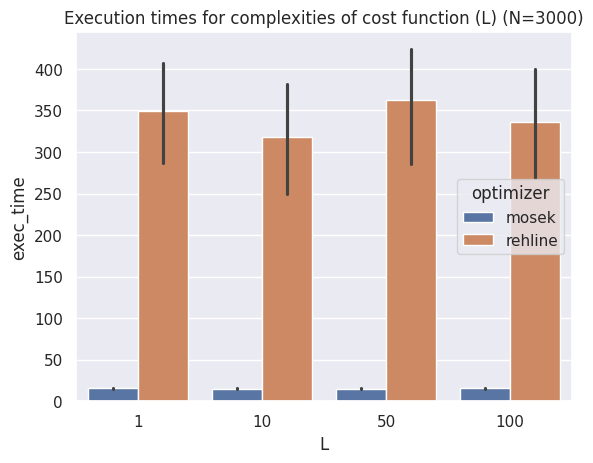

In [39]:
data = pd.DataFrame({
    "L": Ls*(2*n_tries), 
    "optimizer": ["mosek"]*(len(Ls)*n_tries) + ["rehline"]*(len(Ls)*n_tries),
    "exec_time": np.r_[exec_times_mosek.flatten(), exec_times_rehline.flatten()],
})

sns.barplot(data, x="L", y="exec_time", hue="optimizer")
plt.title(f"Execution times for complexities of cost function (L) (N={N})")
plt.show()

# Conclusion

Clearly, ReHLine based portfolio optimization works significantly slower than
convex optimizers like MOSEK for this simulation study. Thus one might wonder
if the real complexity of the ReHLine algorithm is indeed $O(n \log \epsilon^{-1})$
like it's described in the paper, or whether the constant factor is too large
to greatly shirnk its practicability. It is, in fact, the former as the true complexity
of the ReHLine algorithm depends negatively with the smallest eigenvalue, so
for cases when the eigenvalue of a covariance matrix $G$ is very small 
(which was the case for the experiment), the algorithm will work very slowly.
On a brighter side, for a well regularized covariance matrix $G$ ReHLine optimization
method will indeed work significantly faster than generic optimizers like MOSEK or CVXPY
(see `FactorModel.ipynb` for more). 